In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import scipy as sc

In [2]:
from random import randint

class ECPoint():
    
    def __init__(self, x, y, inf=0):
        self.x = x
        self.y = y
        self.inf = inf

    def __eq__(self, other):
        if (self.inf == 1) and (other.inf == 1):
            return True

        return (self.x == other.x) and (self.y == other.y)

    def __repr__(self):
        if self.inf == 1:
            return 'O'
        # print the compressed version
        return '({}, {})'.format(self.x, self.y & 1)

    def __hash__(self):
        return hash(str(self))


class EllipticCurve():

    def __init__(self, p, g, a, b):
        """ A curve is defined by
            p: The finite field Fp
            g: The base point (generator) for the group
            a, b: Curve parameters, Y^2 = X^3 + aX + b
        """
        self.p = p
        self.g = g
        self.a = a
        self.b = b

    def identity(self):
        """ Returns hte identity element. """
        return ECPoint(0, 0, 1)

    def is_valid(self, p):
        """ Checks whether a point P is valid. """
        return p.y**2  % self.p == (p.x**3 + self.a*p.x + self.b) % self.p

    def random_point(self):
        """ Generate a random point (not identity) on the curve. """
        m = randint(1, self.p)
        p = self.mul(self.g, m)
        while p == self.identity():
            m = randint(1, self.p)
            p = self.mul(self.g, m)

        return p

    def egcd(self, a, b):
        if a == 0:
            return (b, 0, 1)
        else:
            g, y, x = self.egcd(b % a, a)
            return (g, x - (b // a) * y, y)

    def modinv(self, a, m):
        g, x, y = self.egcd(a, m)
        if g != 1:
            raise Exception('Modular inverse does not exist')
        else:
            return x % m

    def add(self, p1, p2):
        """ Adds two points P1 = (x1, y1) and P2 = (x2, y2) on the given curve. """
        # special case if one point is O (identity)
        if p1.inf == 1 and p2.inf == 1:
            return self.identity()
        if p1.inf == 1:
            return p2
        if p2.inf == 1:
            return p1

        if p1.x != p2.x:
            lam = ((p2.y - p1.y) * self.modinv((p2.x - p1.x) % self.p, self.p)) % self.p
        else:
            if (p1 == self.neg(p2)):
                return self.identity()
            if (p1.y == 0):
                return self.identity()
            
            # point doubling
            lam = ((3*p1.x**2 + self.a) * self.modinv(2 * p1.y, self.p)) % self.p


        x3 = (lam**2 - p1.x - p2.x) % self.p
        y3 = ((p1.x - x3) * lam - p1.y) % self.p
        return ECPoint(x3, y3)

    def neg(self, p):
        """ Calculate the additive inverse of a point P1, -P1. """
        return ECPoint(p.x, self.p - p.y)

    def sub(self, p1, p2):
        """ Subtract P2 from P1, i.e., P1 - P2 = P1 + (-P2). """
        return self.add(p1, self.neg(p2))

    def mul(self, p, m):
        """ Multiply a point P with a constant m, using double-and-add. """
        result = self.identity()
        addend = p

        while m:
            if m & 1:
                result = self.add(result, addend)

            # double the point
            addend = self.add(addend, addend)
            m >>= 1

        return result

In [3]:
from random import randint
from hashlib import sha256

# from ecc import EllipticCurve, ECPoint

def keygen():
    # use the secp256k1 curve
    p = int('FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFEFFFFFC2F', 16)
    a = 0
    b = 7
    g = ECPoint(int('79BE667EF9DCBBAC55A06295CE870B07029BFCDB2DCE28D959F2815B16F81798', 16), 
        int('483ADA7726A3C4655DA4FBFC0E1108A8FD17B448A68554199C47D08FFB10D4B8', 16))
    G = EllipticCurve(p, g, a, b)

    # generate private key
    x = randint(1, p)
    h = G.mul(g, x)

    return (x, G, g, p, h)


def encrypt(m, G, g, p, h):
    """
    Encryption of plaintext m.
    Parameters
    ----------
    m: The message, a point on the curve
    G: The curve
    g: The curve base point
    p: The order of the field
    h: Public part of the shared secret
    """

    # TODO: implement a padding scheme for m, like OAEP

    y = randint(1, p)
    c1 = G.mul(g, y)
    s = G.mul(h, y)         # h*y = g*xy
    # c2 = m xor H(h*y)
    hs = sha256(repr(s).encode('utf-8')).digest()
#     print (hs)
    c2 = bytearray([i ^ j for i,j in zip(m, hs)])
    return (c1, bytes(c2))


def decrypt(c, x, G):
    """
    Decryption of ciphertext c.
    
    Parameters
    ----------
    c: The ciphertext tuple, (c1, c2)
    x: The private key
    G: The curve
    """
        
    c1, c2 = c
    s = G.mul(c1, x)
    # m = c2 xor H(c1*x)
    hs = sha256(repr(s).encode('utf-8')).digest()
    m = bytearray([i ^ j for i,j in zip(c2, hs)])
    return bytes(m)


# if __name__ == '__main__':
def ecckey(m):
    x, G, g, p, h = keygen()
#     m = input('Enter message: ').encode('utf-8')
    m = m.encode('utf-8')

    c = encrypt(m, G, g, p, h)
    print('Encrypted: {}'.format(c))
    return c[1]
#     mp = decrypt(c, x, G)
#     print('Decrypted:\t{}'.format(mp.decode()))
#     assert m == mp

In [4]:
from Crypto import Random
from Crypto.Cipher import AES
import os
import os.path
from os import listdir
from os.path import isfile, join
import time


class Encryptor:
    def __init__(self, key):
        self.key = key

    def pad(self, s):
        return s + b"\0" * (AES.block_size - len(s) % AES.block_size)

    def encrypt(self, message, key, key_size=256):
#         print (message)
        message = self.pad(message)
#         print (message)
        iv = Random.new().read(AES.block_size)
#         print (iv)
        cipher = AES.new(key, AES.MODE_CBC, iv)
#         print (cipher)
        return iv + cipher.encrypt(message)

    def encrypt_file(self, file_name):
        f = open("Data.txt", "r")
        string = f.read()
        print ("Data.txt file opened: ", string)
        with open(file_name, 'rb') as fo:
            plaintext = fo.read()
        enc = self.encrypt(plaintext, self.key)
        print ("Encrypted Data: ", enc)
        print (type(enc))
#         return enc
#         enc = enc.decode("utf-8")
        with open(file_name + ".enc", 'wb') as fo:
            fo.write(enc)
#         print ("CHECK1")
        f = open("Data.txt.enc", errors = "ignore")
#         print ("Hello")
#         print ("CHECK2")
        string = f.read()
#         print ("Hello")
        print ("Data.txt.enc file opened: ", string)
#         print ("CHECK3")

#         os.remove(file_name)

    def decrypt(self, ciphertext, key):
        iv = ciphertext[:AES.block_size]
        cipher = AES.new(key, AES.MODE_CBC, iv)
        print ("decrypt start...")
        plaintext = cipher.decrypt(ciphertext[AES.block_size:])
        print ("decrypt end")
        return plaintext.rstrip(b"\0")
#         return plaintext

    def decrypt_file(self, file_name):
        with open(file_name, 'rb') as fo:
            ciphertext = fo.read()
#             print (type(ciphertext))
#         ciphertext = ciphertext.decode("utf-8")
#         encoder = PKCS7Encoder()
#         ciphertext = encoder.encode(ciphertext)
#         ciphertext = str.encode(ciphertext)
#         print ("DEC")
        dec = self.decrypt(ciphertext, self.key)
        print (dec)
        dec = dec.decode("utf-8")
        with open("Data2.txt", 'w') as fo:
            fo.write(dec)
        f = open("Data2.txt", "r")
        string = f.read()
        print ("Data2.txt file opened: ", string)
#         print ("DEC")
#         os.remove(file_name)


# key = b'[EX\xc8\xd5\xbfI{\xa2$\x05(\xd5\x18\xbf\xc0\x85)\x10nc\x94\x02)j\xdf\xcb\xc4\x94\x9d(\x9e'
key = '[EX\xc8\xd5\xbfI{\xa2$\x9e'
# key = 'suyashsuyashhere'
key = ecckey(key)
# key = str.encode(key)
enc = Encryptor(key)
enc2 = Encryptor(key)
clear = lambda: os.system('cls')

def aesencrypt():
#     val = enc.encrypt_file("Data.txt")
#     return val
    enc.encrypt_file("Data.txt")
    
def aesdecrypt():
    enc2.decrypt_file("Data2.txt.enc")

# enc.encrypt_file(str(input("Enter name of file to encrypt: ")))
# enc.decrypt_file(str(input("Enter name of file to decrypt: ")))

Encrypted: ((103683873149686966590150963963170667577311450381760033386740869351411970179266, 0), b'K\x199\xe3x\xe5\x16\xabJ\xd5\x06\x12`\xb6\xd7\xcc')


In [5]:
def convert(char):
    return format(ord(char), '016b')

In [6]:
quantization_table = [[16, 11, 10, 16, 24, 40, 51, 61],
                [12, 12, 14, 19, 26, 58, 60, 55],
                [14, 13, 16, 24, 40, 57, 69, 56],
                [14, 17, 22, 29, 51, 87, 80, 62],
                [68, 56, 37, 56, 68, 109, 103, 77],
                [24, 35, 55, 64, 81, 104, 113, 92],
                [49, 64, 78, 87, 103, 121, 120, 101],
                [72, 92, 95, 98, 112, 100, 103, 99]]

In [7]:
def decrypt(image_dct, image):
    data = ''
    image_data = image.astype(float)
    image_data_dct = image_dct.astype(float)
    m, n = image_data.shape
#     image_dct = np.zeros(image.shape)
    x_division = int(m/8)
    y_division = int(n/8)
    
    a = 0
    
    for i in range(0, x_division):
        for j in range(0, y_division):
            x_s = i * 8
            x_e = (i+1) * 8
            y_s = j * 8
            y_e = (j+1) * 8
            lis_dct = cv2.dct(image_data[x_s:x_e,y_s:y_e]) / quantization_table
            lis_dct_new = image_data_dct[x_s:x_e,y_s:y_e]
            
#             if a < 1:
#                 print (lis_dct)
#                 print (lis_dct_new)
#                 a += 1

            for k, l in zip(lis_dct, lis_dct_new):
                for m, n in zip(k, l):
                    if m == n:
#                         print ("Equal")
                        continue
                    elif abs(n - m) >= 1.9 and abs(n - m) <= 2.1:
                        data += '0'
#                         print ("0")
#                         print (data)
                    elif abs(n - m) >= 2.9 and abs(n - m) <= 3.1:
                        data += '1'
#                         print ("1")
#                         print (data)
    
    to_return = ''
    for i in range(0, int(len(data) / 16)):
        substr = data[i * 16 : (i + 1) * 16]
#         print (substr)
        num = int(substr, 2)
#         print (num)
#         print (chr(num))
        to_return += chr(num)
#     print (type(to_return))
        
    print ("Data from image, write in Data2.txt.enc: ", to_return)
    with open("Data2.txt.enc", 'w') as fo:
        fo.write(to_return)
    f = open("Data2.txt.enc", "r")
    string = f.read()
    print ("Data2.txt.enc file opened: ", string)
    aesdecrypt()   
    

In [149]:
def dct(image):
    image_data = image.astype(float)
    m, n = image_data.shape
    image_dct = np.zeros(image.shape)
    x_division = int(m/8)
    y_division = int(n/8)
#     print ('m = ', m)
#     print ('n = ', n)
#     print (x_division)
#     print (y_division)
    
    lis_dct = []
    x = 0
    F = 0
    lis_F = []
    TF = 0.1
    lis_selected = []
    
    T = 0.2
    TL = 0.2
    TH = 0.3
    
    pointer = 0
    
    avg = 0
    
    eof = 0
    
    a = 0
    
#     val = aesencrypt()
    aesencrypt()
    f = open("Data.txt.enc", "r")
#     print ("Hello")
    string = f.read()
#     print ("Hello")
    print ("AES encrypted data, sent to image: ", string)

    
    
    data = ''
    for i in string:
        data += convert(i)
#         print (ord(i))
#     print (string)
#     print (data)
    

    for i in range(0, x_division):
        for j in range(0, y_division):
            x_s = i * 8
            x_e = (i+1) * 8
            y_s = j * 8
            y_e = (j+1) * 8
            image_dct[x_s:x_e, y_s:y_e] = cv2.dct(image_data[x_s:x_e,y_s:y_e]) / quantization_table
            lis_dct = cv2.dct(image_data[x_s:x_e,y_s:y_e]) / quantization_table
            y = 0
            sum_coeff = 0
            avg = 0
            
            if eof == 0:
            
                for l in lis_dct:
                    for k in l:
                        if y == 0:
                            y += 1
                            continue
                        else:
                            y += 1
                            sum_coeff += (k * k)
                            avg += k
    #             print ('sum_coeff = ', sum_coeff)
                F = sum_coeff/64
                avg /= 64
                # Indexes of selected blocks inserted in a list, useful while traversing later
                if F < TF:
                    lis_selected.append((i, j))

                    """ Embedding Code Start """
                    for l in range(0, 8):
                        for m in range(0, 8):
                            k = lis_dct[l][m]
#                             print (k)
    #                         x = k
                            if T >= 0:
            #                     print ("IN1")
            #                     print (abs(x - T))
                                if abs(k - T) <= 0.1 and k < TH and k > TL:
                                    current = 0
#                                     print ("IN2")

                                    if pointer == len(data):
                                        print ("End of file")
                                        eof = 1
                                        break    

                                    c = data[pointer]
                                    pointer += 1
#                                     print ("Read a character:", c)
#                                     print ("Old K: ", k)
                                    if c == '0':
                                        k += 2
                                        lis_dct[l][m] += 2
                                        image_dct[x_s:x_e, y_s:y_e] = lis_dct
#                                         print (l, m)
                                    elif c == '1':
                                        k += 3
                                        lis_dct[l][m] += 3
                                        image_dct[x_s:x_e, y_s:y_e] = lis_dct
#                                         print (l, m)
#                                     print ("New K: ", k)

                                elif (k - T) > 0.1:
                                    k += 1
                                    lis_dct[l][m] += 1
                                    image_dct[x_s:x_e, y_s:y_e] = lis_dct
    #                                 print (k)

                            else:
                                print ("OUT1")
                                if abs(k - T) <= 0.1 and k < TH and k > TL:
                                    current = 0
                                    print ("OUT2")

                                    if pointer == len(data):
                                        print ("End of file")
                                        eof = 1
                                        break

                                    c = data[pointer]
                                    print ("Read a character:", c)
                                    pointer += 1
#                                     print ("Old K: ", k)
                                    if c == '0':
                                        k = -2 - k
                                        lis_dct[l][m] = -2 - lis_dct[l][m]
                                        image_dct[x_s:x_e, y_s:y_e] = lis_dct
                                        print (l, m)
                                    elif c == '1':
                                        k = -3 - k
                                        lis_dct[l][m] = -3 - lis_dct[l][m]
                                        image_dct[x_s:x_e, y_s:y_e] = lis_dct
                                        print (l, m)
#                                     print ("New K: ", k)

                                elif (k - T) < 0.1:
                                    k = -1 - k
                                    lis_dct[l][m] = -1 - lis_dct[l][m]
                                    image_dct[x_s:x_e, y_s:y_e] = lis_dct
                    """ Embedding Code Finish """


                lis_F.append(F)
    #             if x < 5:
    #                 print (F)
    #                 print (lis_dct)
    #                 print (avg)
    #                 x += 1
    #                 print ('y = ', y)

#     print ("Avg is ", sum(lis_F) / len(lis_F))
#     print (lis_F)
#     print (data)
#     print ("Length of lis_F = ", len(lis_F))
#     print ("Length of lis_selected = ", len(lis_selected))
#     print (lis_selected)
    return image_dct




In [9]:
import numpy 
import math
import cv2
# original = cv2.imread("original.png")
# contrast = cv2.imread("photoshopped.png",1)
def psnr(img1, img2):
    mse = numpy.mean( (img1 - img2) ** 2 )
    if mse == 0:
        return 100
    PIXEL_MAX = 255.0
    return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))

# d=psnr(original,contrast)
# print(d)

In [215]:
image = cv2.imread('airplane.jpeg', 0)
# print (image.size)

import time
start_time = time.time()
# main()

# DCT
image_dct = dct(image)
print("--- %s seconds ---" % (time.time() - start_time))
# print (image_dct.size * image_dct.itemsize / 8)
# print (type(image_dct))

import os
# os.path.getsize('github.jpeg')
print (os.stat('airplane.jpeg').st_size)

import scipy.misc
scipy.misc.imsave('airplane2.jpeg', image_dct)

import os
# os.path.getsize('github2.jpeg')
print (os.stat('airplane2.jpeg').st_size)

decrypt(image_dct, image)
print("--- %s seconds ---" % (time.time() - start_time))
psnr(image, image_dct)

# import os
# print (os.stat('github.jpeg').st_size)
# os.path.getsize(image_dct)

# plt.subplot(131)
# plt.imshow(image, 'gray')
# plt.title('original image')
# plt.xticks([]), plt.yticks([])

# plt.subplot(132)
# plt.imshow(image_dct, 'gray')
# plt.title('dct')
# plt.xticks([]), plt.yticks([])

Data.txt file opened:  1234567891234567
Encrypted Data:  b'I\xb5\xbe1\xe05\x03\x9f\x02_\xa7\x17\xf0\x9eR{h\xfd7#.]`\x85\x83\x84\xc13\xf5\xe7p\xc7\xbb[!\xf0\xbag\x83\xe4\xf0\x84aj\xf0$\xfa\xde'
<class 'bytes'>
Data.txt.enc file opened:  Iµ¾1à5Ÿ_§ðžR{hý7#.]`…ƒ„Á3õçpÇ»[!ðºgƒäð„ajð$úÞ
AES encrypted data, sent to image:  Iµ¾1à5Ÿ_§ðžR{hý7#.]`…ƒ„Á3õçpÇ»[!ðºgƒäð„ajð$úÞ
End of file
--- 3.5020751953125 seconds ---
77564


c:\program files\python36\lib\site-packages\ipykernel_launcher.py:19: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


217445
Data from image, write in Data2.txt.enc:  Iµ¾1à5Ÿ_§ðžR{hý7#.]`…ƒ„Á3õçpÇ»[!ðºgƒäð„ajð$úÞ
Data2.txt.enc file opened:  Iµ¾1à5Ÿ_§ðžR{hý7#.]`…ƒ„Á3õçpÇ»[!ðºgƒäð„ajð$úÞ
decrypt start...
decrypt end
b'1234567891234567'
Data2.txt file opened:  1234567891234567
--- 5.2127509117126465 seconds ---


3.6476776949270757

In [205]:
print (217447 - 77564)

139883


Text(0,0.5,'PSNR')

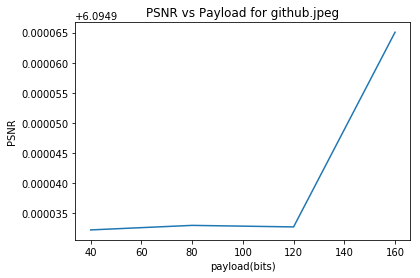

In [132]:
import matplotlib.pyplot as plt

a1 = [6.0949321813534105, 6.0949329357801005, 6.094932680260721, 6.094965062224854]
b1 = [40, 80, 120, 160]

plt.plot(b1, a1, label = 'github.jpeg')
plt.title('PSNR vs Payload for github.jpeg')
plt.xlabel('payload(bits)') 
plt.ylabel('PSNR') 

Text(0,0.5,'rate %')

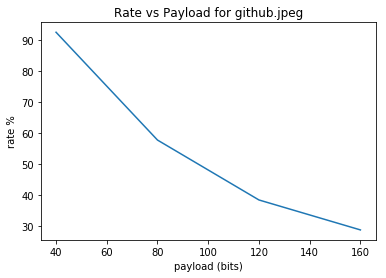

In [131]:
a1 = [92.42040000000001, 57.759625, 38.50275, 28.874125]
a2 = [40, 80, 120, 160]
plt.plot(a2, a1)
plt.title('Rate vs Payload for github.jpeg')
plt.xlabel('payload (bits)') 
plt.ylabel('rate %')

Text(0,0.5,'PSNR')

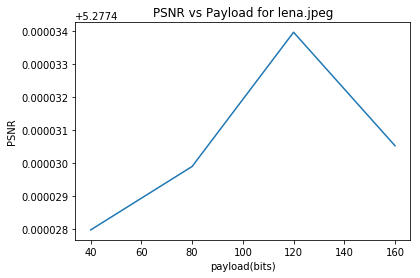

In [130]:
a1 = [5.277427983815343, 5.277429900148979, 5.277433953685549, 5.277430525184002]
a2 = [40, 80, 120, 160]
plt.plot(a2, a1)
plt.title('PSNR vs Payload for lena.jpeg')
plt.xlabel('payload(bits)') 
plt.ylabel('PSNR') 

Text(0,0.5,'rate %')

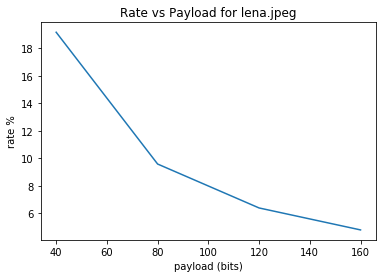

In [129]:
a1 = [19.18375, 9.5865, 6.387666666666666, 4.7884375]
a2 = [40, 80, 120, 160]
plt.plot(a2, a1)
plt.title('Rate vs Payload for lena.jpeg')
plt.xlabel('payload (bits)') 
plt.ylabel('rate %')

Text(0,0.5,'PSNR')

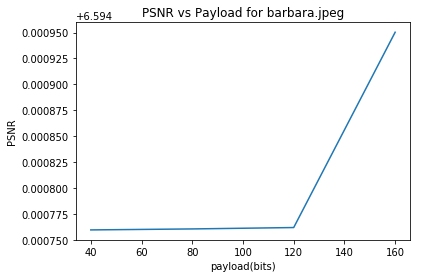

In [100]:
a1 = [6.594759535701017, 6.594760484969553, 6.594761825450977, 6.594950342548458]
b1 = [40, 80, 120, 160]

plt.plot(b1, a1)
plt.title('PSNR vs Payload for barbara.jpeg')
plt.xlabel('payload(bits)') 
plt.ylabel('PSNR') 

Text(0,0.5,'rate %')

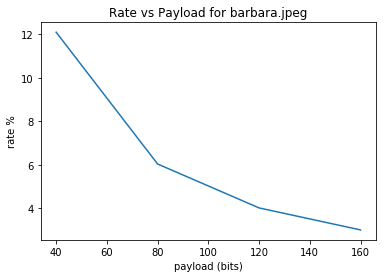

In [101]:
a1 = [12.0925, 6.04125, 4.02425, 3.014375]
a2 = [40, 80, 120, 160]
plt.plot(a2, a1)
plt.title('Rate vs Payload for barbara.jpeg')
plt.xlabel('payload (bits)') 
plt.ylabel('rate %')

Text(0,0.5,'PSNR')

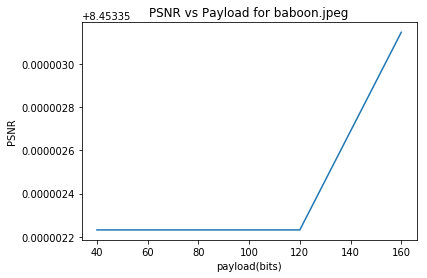

In [151]:
a1 = [8.453352232286973, 8.453352232286973, 8.453352232286973, 8.45335314607372]
b1 = [40, 80, 120, 160]

plt.plot(b1, a1)
plt.title('PSNR vs Payload for baboon.jpeg')
plt.xlabel('payload(bits)') 
plt.ylabel('PSNR') 

Text(0,0.5,'rate %')

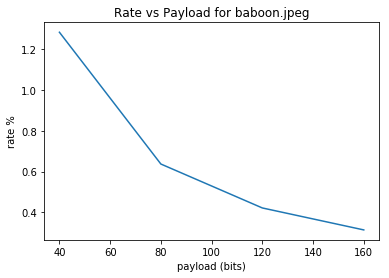

In [152]:
a1 = [1.2834999999999999, 0.6367499999999999, 0.4211666666666667, 0.31337499999999996]
a2 = [40, 80, 120, 160]
plt.plot(a2, a1)
plt.title('Rate vs Payload for baboon.jpeg')
plt.xlabel('payload (bits)') 
plt.ylabel('rate %')

In [126]:
rate = (217266 - 77564 - 160) / 160
print ((rate)/100)

8.721375


Text(0,0.5,'PSNR')

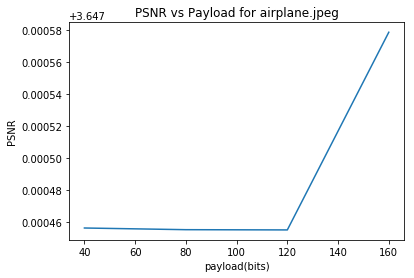

In [127]:
a1 = [3.647456468347643, 3.647455420488141, 3.647455274403405, 3.647578715564062]
b1 = [40, 80, 120, 160]

plt.plot(b1, a1)
plt.title('PSNR vs Payload for airplane.jpeg')
plt.xlabel('payload(bits)') 
plt.ylabel('PSNR') 

Text(0,0.5,'rate %')

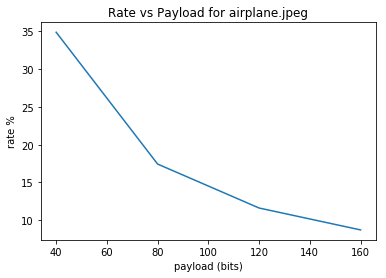

In [128]:
a1 = [34.882, 17.43675, 11.6205, 8.721375]
a2 = [40, 80, 120, 160]
plt.plot(a2, a1)
plt.title('Rate vs Payload for airplane.jpeg')
plt.xlabel('payload (bits)') 
plt.ylabel('rate %')